**Sweet Lift Taxi - Predicting the Number of Taxi Orders**
---


### Introduction
---
Sweet Lift Taxi company seeks to improve driver availability during peak hours by forecasting taxi orders for the upcoming hour. Historical airport order data provided the foundation to develop a forecasting model with a test set RMSE metric not exceeding 48. The final Random Forest model achieved an RMSE of 41.9, meeting the threshold and offering reliable predictions for optimized driver allocation. Historical data on taxi orders at airports was collected, and different time series were tested. A model was built to predict the volume of taxi orders for the next hour, attracting more drivers during peak periods.


### Importing libraries
---

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.ensemble import RandomForestRegressor
from pmdarima import auto_arima
import seaborn as sns
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings

In [56]:
warnings.filterwarnings("ignore")


### Importing dataset
---

In [7]:
df = pd.read_csv(r"C:\Users\galdi\OneDrive\Área de Trabalho\New folder\Triple Ten\Sprint 13\taxi.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


### Exploratory Data Analysis (EDA)
---

In [8]:
df['datetime'] = df['datetime'].astype('datetime64[ns]')
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [9]:
df.set_index('datetime', inplace=True)

In [10]:
df = df.resample('H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [11]:
print(df.isna().sum())

num_orders    0
dtype: int64


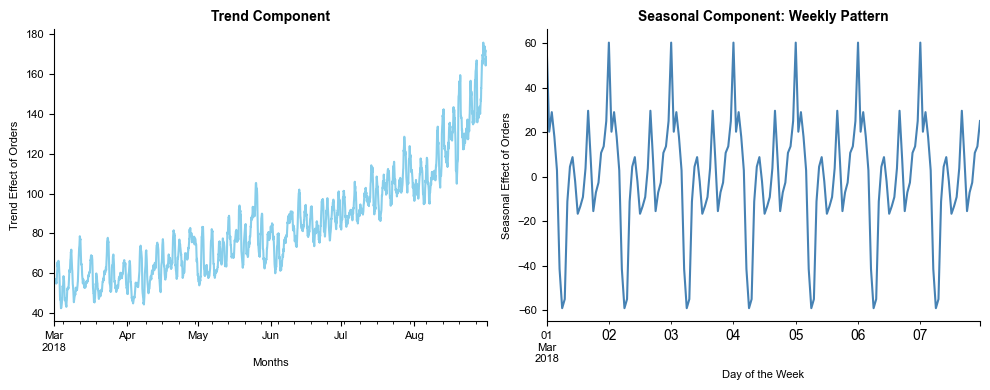

In [21]:
decomposition = seasonal_decompose(df['num_orders'], model='additive')

hours_per_day = 24
days_per_week = 7
hours_in_week = hours_per_day * days_per_week

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3) 

decomposition.trend.plot(ax=axes[0], color="skyblue")
axes[0].set_xlabel("Months", fontsize=8)
axes[0].set_ylabel("Trend Effect of Orders", fontsize=8)
axes[0].set_title("Trend Component", fontsize=10, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=8)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

decomposition.seasonal[0:hours_in_week].plot(ax=axes[1], color="steelblue")
axes[1].set_xlabel("Day of the Week", fontsize=8)
axes[1].set_ylabel("Seasonal Effect of Orders", fontsize=8)
axes[1].set_title("Seasonal Component: Weekly Pattern", fontsize=10, fontweight='bold')
axes[1].tick_params(axis='x', labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

- During the exploratory data analysis (EDA), the date column was converted from an object to datetime64 to ensure the correct data type and then set as the index. The data was also resampled to hourly frequency. 

- The charts decomposed the data into its trend and seasonal components, with the seasonal component revealing a consistent pattern, indicating clear seasonality in the number of orders.
---

### Training
---

In [26]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
df_stationarityTest = adfuller(train, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  0.0007322730527364528


- The Augmented Dickey-Fuller (ADF) test is a statistical tool for detecting a unit root in a time series, which indicates non-stationarity. The test assesses the null hypothesis that the series is non-stationary against the alternative of stationarity. A low p-value leads to rejection of the null hypothesis, confirming that the dataset is stationary.
---

### Testing
---

#### Autoregressive model
---

RSME AR: 69.9186



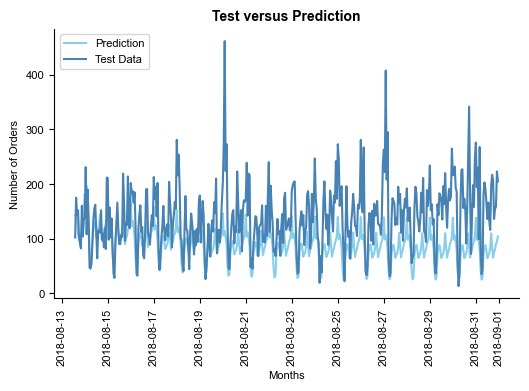

In [48]:
mod = ar_select_order(endog=train, maxlag=30)
ar_order = mod.ar_lags
ar_model = AutoReg(train, lags=ar_order, seasonal=True)
ar_model = ar_model.fit()

start_value = len(train)
end_value = len(train) + len(test) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

MSE_ar = mean_squared_error(test, ar_pred)  
RMSE_ar = np.sqrt(MSE_ar)

print("RSME AR:", RMSE_ar.round(4))
print()

plt.figure(figsize=(6, 3.5))
plt.plot(ar_pred, color='skyblue', label='Prediction') 
plt.plot(test, color='steelblue', label='Test Data')
plt.legend(loc="upper left", fontsize=8)
plt.xlabel("Months", fontsize=8)
plt.ylabel("Number of Orders", fontsize=8)
plt.title("Test versus Prediction", fontsize=10, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

#### Moving average model
---

RSME MA: 84.6765



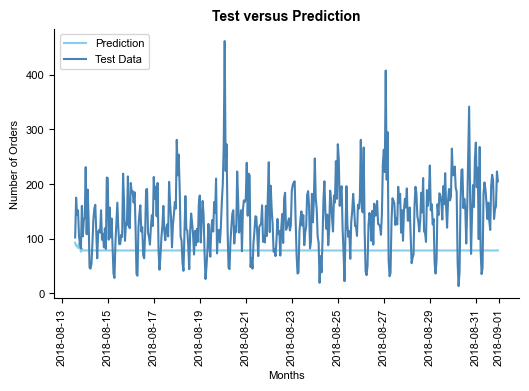

In [53]:
res = arma_order_select_ic(y=train, max_ar=0, max_ma=10)  
ma_order = res.bic_min_order[1] 
ma_model = ARIMA(train, order=(0,0, ma_order))   
ma_model = ma_model.fit()

start_value = len(train)
end_value = len(train) + len(test) - 1 
ma_pred = ma_model.predict(start=start_value, end=end_value, dynamic=False)

MSE_ma = mean_squared_error(test, ma_pred)  
RMSE_ma = np.sqrt(MSE_ma)

print("RSME MA:", RMSE_ma.round(4))
print()

plt.figure(figsize=(6, 3.5))
plt.plot(ma_pred, color='skyblue', label='Prediction') 
plt.plot(test, color='steelblue', label='Test Data')
plt.legend(loc="upper left", fontsize=8)  
plt.xlabel("Months", fontsize=8)
plt.ylabel("Number of Orders", fontsize=8)
plt.title("Test versus Prediction", fontsize=10, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

plt.show()

#### Autoregressive moving average model
---

Best model: ar_order = 2, ma_order = 4, RSME ARMA: 64.0161



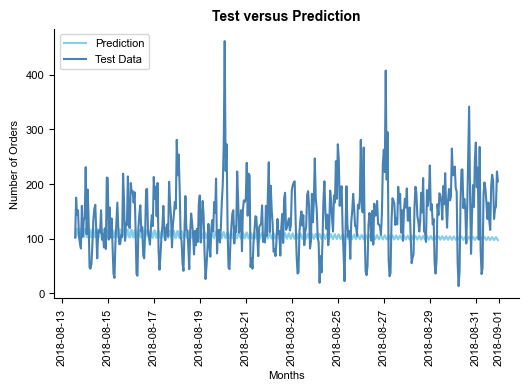

In [58]:
best_score = np.inf
best_ar_order = 0
best_ma_order = 0

for ar_order in range(1, 5):
    for ma_order in range(1, 5):

        arma_full_order = (ar_order, 0, ma_order) 
        arma_model = ARIMA(train, order=arma_full_order) 
        arma_model = arma_model.fit()

        start_value = len(train)
        end_value = len(train) + len(test) - 1 
        arma_pred = arma_model.predict(start=start_value, end=end_value, dynamic=False)

        MSE_arma = mean_squared_error(test, arma_pred)  
        RMSE_arma = np.sqrt(MSE_arma)

        if RMSE_arma < best_score:
            best_score = RMSE_arma
            best_ar_order = ar_order
            best_ma_order = ma_order  
        
print(f"Best model: ar_order = {best_ar_order}, ma_order = {best_ma_order}, RSME ARMA: {best_score:.4f}")    
print()

plt.figure(figsize=(6, 3.5))
plt.plot(arma_pred, color='skyblue', label='Prediction') 
plt.plot(test, color='steelblue', label='Test Data')
plt.legend(loc="upper left", fontsize=8)  
plt.xlabel("Months", fontsize=8)
plt.ylabel("Number of Orders", fontsize=8)
plt.title("Test versus Prediction", fontsize=10, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

plt.show()


#### Autoregressive integrated moving average model
---

RSME ARIMA: 58.7512



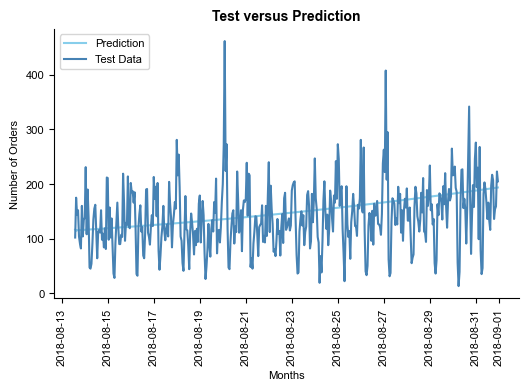

In [61]:
arima_full_order = (2, 3, 2)  
arima_model = ARIMA(train, order=arima_full_order)
arima_model = arima_model.fit()

start_value = len(train)
end_value = len(train) + len(test) - 1 
arima_pred = arima_model.predict(start=start_value, end=end_value, dynamic=False)

MSE_arima = mean_squared_error(test, arima_pred)  
RMSE_arima = np.sqrt(MSE_arima)

print("RSME ARIMA:", RMSE_arima.round(4))
print()

plt.figure(figsize=(6, 3.5))
plt.plot(arima_pred, color='skyblue', label='Prediction') 
plt.plot(test, color='steelblue', label='Test Data')
plt.legend(loc="upper left", fontsize=8)  
plt.xlabel("Months", fontsize=8)
plt.ylabel("Number of Orders", fontsize=8)
plt.title("Test versus Prediction", fontsize=10, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

plt.show()

#### Seasonal Autoregressive Integrated Moving Average
---

RSME SARIMA: 65.3513



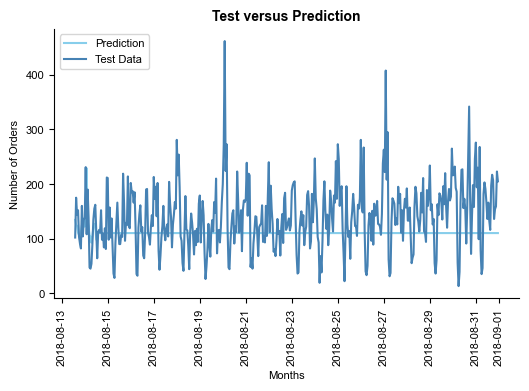

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3974
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood              -19208.997
Date:                                 Fri, 28 Feb 2025   AIC                          38425.994
Time:                                         10:06:42   BIC                          38451.144
Sample:                                     03-01-2018   HQIC                         38434.912
                                          - 08-13-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6830      0.009    -73.493      0.000      -0.701      -0.665
ma.S.L12       0.0703      0.015      4.802      0.000       0.042       0.099
ma.S.L24       0.3785      0.015     25.796      0.000       0.350       0.407
sigma2       925.9271     15.026     61.623      0.000     896.477     955.377
===================================================================================
Ljung-Box (L1) (Q):                  75.94   Jarque-Bera (JB):               709.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
model = auto_arima(train, seasonal=True, m=12, scoring='mse')
predictions = model.predict(len(test))
x = np.zeros(len(df)) 
x[:len(train)] = np.nan
x[len(train):] = predictions
df['predicted_num_orders'] = x
auto_arima_rsme = np.sqrt(mean_squared_error(test, predictions))

print("RSME SARIMA:", auto_arima_rsme.round(4))
print()

plt.figure(figsize=(6, 3.5))
plt.plot(predictions, color='skyblue', label='Prediction') 
plt.plot(test, color='steelblue', label='Test Data')
plt.legend(loc="upper left", fontsize=8)  
plt.xlabel("Months", fontsize=8)
plt.ylabel("Number of Orders", fontsize=8)
plt.title("Test versus Prediction", fontsize=10, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

plt.show()
model.summary()

- During testing, five models were evaluated using RMSE as the quality metric, with a target threshold of 48 or below. 

- The tested models included autoregressive, moving average, autoregressive moving average, autoregressive integrated moving average (ARIMA), and seasonal autoregressive integrated moving average (SARIMA). 

- While the models produced varying RMSE values, none achieved satisfactory results. The best performance came from the ARIMA model, with an RMSE of 58.75. For the SARIMA model, auto_arima was used to identify the optimal combination of parameters (p, d, q), but it also fell short of the threshold at 65.35. 

- Due to these results, the analysis was expanded to include the Random Forest model.
--- 

#### Random Forest
---

In [65]:
df_new = df

In [66]:
df_new = df_new.drop('predicted_num_orders', axis=1)

In [67]:
df_new['year'] = df_new.index.year 
df_new['dayofweek'] = df_new.index.dayofweek
df_new['hourofday'] = df_new.index.hour
df_new['lag_1'] = df_new['num_orders'].shift(1)
df_new['lag_2'] = df_new['num_orders'].shift(2)
df_new['rolling_mean'] = df_new['num_orders'].rolling(10).mean()
df_new = df_new.dropna()
df_new = df_new.reset_index()
df_new

,datetime,num_orders,year,dayofweek,hourofday,lag_1,lag_2,rolling_mean
0,2018-03-01 09:00:00,69,2018,3,9,34.0,15.0,52.5
1,2018-03-01 10:00:00,64,2018,3,10,69.0,34.0,46.5
2,2018-03-01 11:00:00,96,2018,3,11,64.0,69.0,47.6
3,2018-03-01 12:00:00,30,2018,3,12,96.0,64.0,43.5
4,2018-03-01 13:00:00,32,2018,3,13,30.0,96.0,40.1
...,...,...,...,...,...,...,...,...
4402,2018-08-31 19:00:00,136,2018,4,19,207.0,217.0,166.6
4403,2018-08-31 20:00:00,154,2018,4,20,136.0,207.0,162.9
4404,2018-08-31 21:00:00,159,2018,4,21,154.0,136.0,162.1
4405,2018-08-31 22:00:00,223,2018,4,22,159.0,154.0,170.8


In [68]:
features = df_new.drop(['num_orders','datetime'], axis=1)
target = df_new['num_orders']

In [69]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [70]:
model = RandomForestRegressor()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
random_forest_rsme = np.sqrt(mean_squared_error(target_test, predictions))

print("RSME Random Forest:", random_forest_rsme.round(4))


RSME Random Forest: 41.9439


- To run the Random Forest model, the dataset was modified to include new columns as features—specifically, the year, day of the week, hour of the day, lags, and the rolling mean of the num_orders data.

- Next, these new columns were designated as features while num_orders was set as the target variable. Rows with NaN values, introduced by the lag and rolling mean calculations, were removed to prevent issues with the train-test split. The shuffle parameter was set to False to preserve the chronological order of the time series data. After running the model, an RMSE of 41.94 was achieved, which is significantly better than the performance of other models and below the threshold of 48. Consequently, this model is considered the best performer for the task.
---

### Conclusion
---
This project aimed to forecast the number of orders using various models while maintaining an RMSE threshold of 48 or below. Traditional time series models such as ARIMA and SARIMA were tested, but their RMSE values did not meet the target. To improve results, a Random Forest model was implemented by introducing additional features, such as year, day of the week, hour, lags, and rolling means. After addressing NaN values and ensuring chronological order in the train-test split, the Random Forest model achieved an RMSE of 41.94, outperforming all other models and meeting the threshold. This demonstrates the effectiveness of incorporating feature engineering and machine learning for time series forecasting.

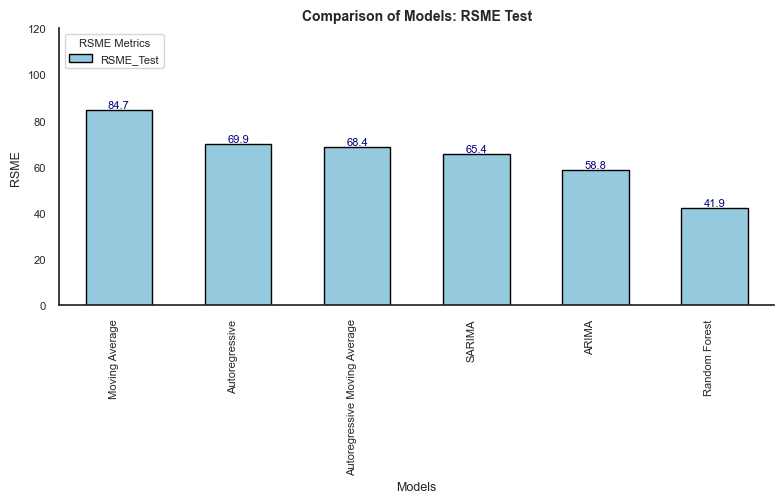

In [105]:
Models = ['Autoregressive', 'Moving Average', 'Autoregressive Moving Average', 'ARIMA', 'SARIMA', 'Random Forest']
RMSE_vars = [RMSE_ar, RMSE_ma, RMSE_arma, RMSE_arima, auto_arima_rsme, random_forest_rsme]

data = pd.DataFrame({'Models': Models, 'RSME_Test': RMSE_vars})
data = data.sort_values(by='RSME_Test', ascending=False)

melted_data = data.melt(id_vars=['Models'], value_vars=['RSME_Test'],
                        var_name='Metric', value_name='RSME')

sns.set_theme(style="white", palette="Blues_d")

fig, ax1 = plt.subplots(figsize=(8, 5.2))
custom_palette = {'RSME_Test': 'skyblue'}

sns.barplot(data=melted_data, x='Models', y='RSME', hue='Metric', ax=ax1,
            palette=custom_palette, edgecolor='black')

ax1.grid(False)

ax1.set_ylabel('RSME', fontsize=9)
ax1.set_xlabel('Models', fontsize=9)
ax1.set_ylim(0, 120)
ax1.tick_params(axis='y', labelsize=8)
ax1.set_title('Comparison of Models: RSME Test', fontweight='bold', fontsize=10)
ax1.legend(loc='upper left', title='RSME Metrics', fontsize=8, title_fontsize=8)
ax1.set_xticklabels(data['Models'], rotation=90, ha='right', fontsize=8)

for patch in ax1.patches:
    current_width = patch.get_width()
    new_width = current_width * 0.7  
    diff = current_width - new_width
    patch.set_width(new_width)
    patch.set_x(patch.get_x() + diff / 2)
    
    height = patch.get_height()
    if height != 0:
        ax1.annotate(f'{height:.1f}', 
                     (patch.get_x() + new_width / 2, height),
                     ha='center', va='bottom', fontsize=8, color='navy')

plt.tight_layout()

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

plt.show()